In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

Write a function `get_data(N)` that produces samples and labels from two multivariate Gaussians

* 1 Gaussian with `mean = [0,0]` and covariance matrix `cov = [[1,0],[0,1]]`, these samples should be labeled `0`
* 1 Gaussian with `mean = [1,1]` and covariance matrix `cov = [[1,0.8],[0.8,1.0]]`. These samples should be labeled `1`

The output of the function should have the following shapes:

* samples = `(2*N,2)`
* labels = `(2*N,1)`

where `N` is the number of samples per Gaussian

In [3]:
def get_data(N):
    x1 = np.random.multivariate_normal([1,1],[[1,0],[0,1]], size = N)
    x2 = np.random.multivariate_normal([0,0],[[1,0.8],[0.8,1]], size = N)
    X = np.concatenate([x1,x2])
    
    y1 = np.zeros(N)
    y2 = np.ones(N)
    y = np.concatenate([y1,y2])
    return torch.tensor(X).float(),torch.tensor(y).float()

Draw a sample of `N=1000` and visualize it in the `(x1,x2)` and color the markers according to the label

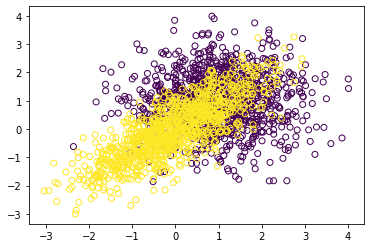

In [4]:
X,y = get_data(1000)
plt.scatter(X[:,0],X[:,1], marker = 'o', facecolor = 'none', edgecolor = plt.get_cmap('viridis')(y))

Write a logistic regression $p(z|f_{W,b}(x))$ with $$f_{W,b}(x) = \sigma(Wx + b)$$
as a PyTorch module

In [5]:
class NeuralNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(1,2))
        self.b = torch.nn.Parameter(torch.randn(1))
        
    def forward(self,x):
        return torch.sigmoid(torch.einsum('ij,bj',self.W,x) + self.b)

Write a function `train_model_infinite_data(model,nsteps)` using the PyTorch's Adam optimizer and learning rate 1e-3 that trains the logistic model as a classification model (i.e. the cross entropy loss). The optimization should proceed for `nsteps` steps and return the trained model as well as the progression of loss values.

For each step of the optimization draw a new independent sample using `get_data` (i.e. this is the case where you would have infinite data)

In [6]:
def train_model_infinite_data(model,nsteps = 5000):
    losses = []
    opt = torch.optim.Adam(model.parameters(), 1e-3)
    for i in range(nsteps):
        X,y = get_data(500)
        p = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p[:,0],y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses.append(float(loss))
        if i % 1000 == 0:
            print(float(loss))
    return model,losses

Train the linear regression model using `train_model_infinite_data` and plot the loss as a function of optimization steps.

1.0985058546066284
0.7687260508537292
0.5981682538986206
0.543083906173706
0.5384361147880554


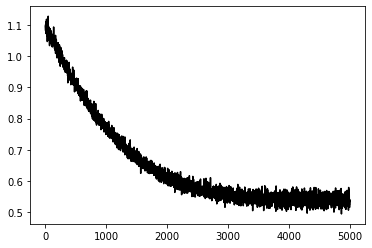

In [7]:
model_shallow_infinite, losses_shallow_infinite = train_model_infinite_data(NeuralNet())
plt.plot(losses_shallow_infinite, c = 'k')

Write a function `plot_decision_boundary` that plots a contour plot for a given $f_\phi$. Visualize the trained model from above.

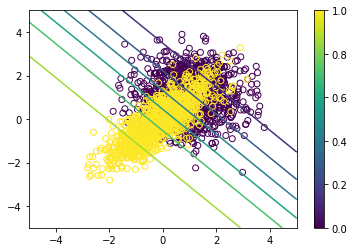

In [8]:
def plot_decision_boundary(model, data):
    X,y = data
    grid = np.mgrid[-5:5:1001j,-5:5:1001j]
    Xi = np.swapaxes(grid,0,-1).reshape(-1,2)
    yi = model(torch.FloatTensor(Xi)).detach()[:,0]
    yi = yi.reshape(1001,1001).T
    plt.contour(grid[0],grid[1],yi)
    plt.scatter(X[:,0],X[:,1], marker = 'o', facecolor = 'none', edgecolor = plt.get_cmap('viridis')(y))
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.colorbar()
    
plot_decision_boundary(model_shallow_infinite, data = get_data(1000))

Using the `torch.nn.Sequential` API, build a deep network and repeat the above analysis.

0.6941291689872742
0.4517330825328827
0.4553781747817993
0.4609261453151703
0.4290086030960083


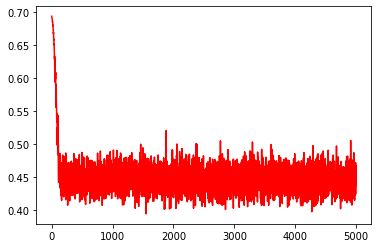

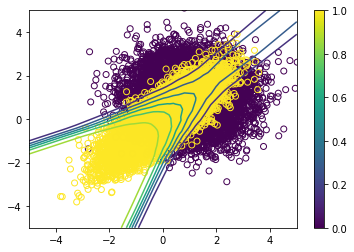

In [9]:
deep_net = lambda: torch.nn.Sequential(
    torch.nn.Linear(2,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,1),
    torch.nn.Sigmoid()
)
    
    
model_deep_infinite, losses_deep_infinite = train_model_infinite_data(deep_net())
plt.plot(losses_deep_infinite, c = 'r')
plt.show()
plot_decision_boundary(model_deep_infinite, get_data(10000))

Compare the Performance in the infinite data limit between the shallow and deep model. Discuss the results. Which one is better? Why does there seem to be a lower bound for the deep model?

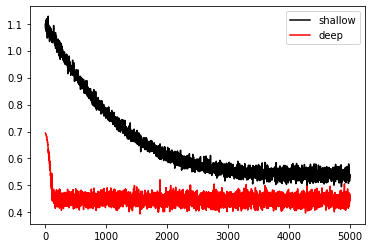

In [10]:
plt.plot(losses_shallow_infinite, label = 'shallow', c = 'k')
plt.plot(losses_deep_infinite, label = 'deep', c = 'r')
plt.legend()

Write a function `def log_lhood_ratio` that computes the likelihood ratio for a given point $x$. Create a scatter plot of the likelihood ratio vs the two model output probabilities

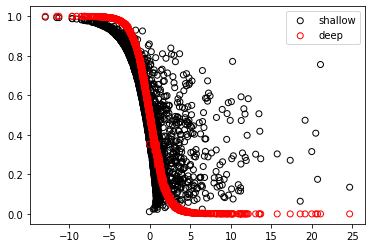

In [25]:
import scipy.stats as sps
def log_lhood_ratio(x):
    l1 = sps.multivariate_normal([1,1],[[1,0],[0,1]]).logpdf(x)
    l2 = sps.multivariate_normal([0,0],[[1,0.8],[0.8,1]]).logpdf(x)
    return l1-l2

X,_ = get_data(1000)
LR = log_lhood_ratio(X)
SC_shal = model_shallow_infinite(X).detach().ravel()
SC_deep = model_deep_infinite(X).detach().ravel()
plt.scatter(LR,SC_shal, marker = 'o', facecolor = 'none', edgecolor = 'k', label = 'shallow')
plt.scatter(LR,SC_deep, marker = 'o', facecolor = 'none', edgecolors='r', label = 'deep')
plt.legend()